<font size="+3"><strong>Housing Price Predictor for Buenos Aires 🇦🇷</strong></font>

<font size="+2"><strong>Part 4: Predicting Housing Price With Size, Location, And Neighborhood </strong></font>

In [1]:
__author__ = "Donald Ghazi"
__email__ = "donald@donaldghazi.com"
__website__ = "donaldghazi.com"

This project builds on my `Predicting Housing Price with Size`, `Predicting Housing Price with Location`, `Predicting Housing Price with Neighborhood` projects.

This is the final project for the series and I'm going to try to use all the features in my dataset to improve my model. Up until now, I've been trying to predict apartment price by looking at one or two features at a time. I started with size to see if I can predict price that way. Then I looked at location. Both in terms of latitude and longitude. And finally in terms of neighborhood. And this time I want to take all of those things and put them together. This means that I'll have to do a more careful cleaning of the dataset and consider some of the finer points of linear models.

In [57]:
import warnings
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from glob import glob
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from ipywidgets.embed import embed_minimal_html
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
from IPython.display import display

warnings.simplefilter(action="ignore", category=FutureWarning)

GOALS
- Build a model to predict apartment price.
- Evaluate all of the features in my dataset for use in my model.
- Create two deployments of my trained model.

Machine Learning Workflow

1. Prepare Data
    - Import: wrangle function & list comprehension
    - Explore: Null values, high- and low-cardinality, leakage, multicollinearity.
    - Split


2. Build Model
    - Baseline
    - Iterate
    - Evaluate


3. Communicate Results
    - make_prediction function
    - Interactive dashboard MVP

# Prepare Data

## Import

In [3]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    return df

**Collect File Names**

In [4]:
# Use glob to create a list that contains the filenames for all the Buenos Aires real estate CSV files in the data directory
files = glob("data/buenos-aires-real-estate-*.csv") # Assign this list to the variable name files
files

['data/buenos-aires-real-estate-3.csv',
 'data/buenos-aires-real-estate-2.csv',
 'data/buenos-aires-real-estate-1.csv',
 'data/buenos-aires-real-estate-5.csv',
 'data/buenos-aires-real-estate-4.csv']

In my past Buenos Aires projects, I put all my DataFrames into a list by using a `for` loop. This time I'm going to use a more compact coding technique called a **list comprehension**. 

**Wrangle With List Comprehension**

In [5]:
# For loop I used previously (commenting for reference and won't run it)
#frames = []
#for file in files:
   # df = wrangle(file)
   # frames.append(df)

In [6]:
# Use my wrangle function in a list comprehension to create a list named frames
frames = [wrangle(file) for file in files] # The list should contain the cleaned DataFrames for the filenames I collected in files

In [7]:
# Inspect frames
type(frames)

list

In [8]:
# Length of frames
len(frames)

5

There are 5 items in this list.

In [9]:
# Look at type for first item of frames
type(frames[0])

pandas.core.frame.DataFrame

In [10]:
frames[0].head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
7,sell,apartment,120000.0,USD,1819488.00,120000.0,NaN,55.0,NaN,2181.818182,NaN,2.0,NaN,http://villa-general-mitre.properati.com.ar/xx...,-34.616004,-58.470506,Villa General Mitre
20,sell,apartment,89000.0,USD,1349453.60,89000.0,NaN,37.0,NaN,2405.405405,7.0,2.0,NaN,http://palermo.properati.com.ar/ya5i_venta_dep...,-34.584712,-58.444927,Palermo
21,sell,apartment,183495.0,USD,2782224.58,183495.0,92.0,57.0,1994.51087,3219.210526,NaN,2.0,NaN,http://saavedra.properati.com.ar/12izq_venta_d...,-34.554652,-58.493644,Saavedra
41,sell,apartment,95000.0,USD,1440428.00,95000.0,53.0,47.0,1792.45283,2021.276596,NaN,2.0,NaN,http://villa-del-parque.properati.com.ar/wy0n_...,-34.610581,-58.479625,Villa del Parque
43,sell,apartment,95000.0,USD,1440428.00,95000.0,0.0,35.0,NaN,2714.285714,NaN,1.0,NaN,http://belgrano.properati.com.ar/xw9a_venta_de...,-34.558227,-58.458357,Belgrano


Last step: Combine the DataFrames in `frames` into a single `df`.

**Concatenate DataFrames**

In [11]:
# Use pd.concat to concatenate it items in frames into a single DataFrame df
df = pd.concat(frames, ignore_index = True) # Set the ignore_index argument to True
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   6582 non-null   object 
 1   property_type               6582 non-null   object 
 2   price                       6582 non-null   float64
 3   currency                    6582 non-null   object 
 4   price_aprox_local_currency  6582 non-null   float64
 5   price_aprox_usd             6582 non-null   float64
 6   surface_total_in_m2         4752 non-null   float64
 7   surface_covered_in_m2       6582 non-null   float64
 8   price_usd_per_m2            4536 non-null   float64
 9   price_per_m2                6582 non-null   float64
 10  floor                       1900 non-null   float64
 11  rooms                       5286 non-null   float64
 12  expenses                    1739 non-null   object 
 13  properati_url               6582 

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
0,sell,apartment,120000.0,USD,1819488.00,120000.0,NaN,55.0,NaN,2181.818182,NaN,2.0,NaN,http://villa-general-mitre.properati.com.ar/xx...,-34.616004,-58.470506,Villa General Mitre
1,sell,apartment,89000.0,USD,1349453.60,89000.0,NaN,37.0,NaN,2405.405405,7.0,2.0,NaN,http://palermo.properati.com.ar/ya5i_venta_dep...,-34.584712,-58.444927,Palermo
2,sell,apartment,183495.0,USD,2782224.58,183495.0,92.0,57.0,1994.51087,3219.210526,NaN,2.0,NaN,http://saavedra.properati.com.ar/12izq_venta_d...,-34.554652,-58.493644,Saavedra
3,sell,apartment,95000.0,USD,1440428.00,95000.0,53.0,47.0,1792.45283,2021.276596,NaN,2.0,NaN,http://villa-del-parque.properati.com.ar/wy0n_...,-34.610581,-58.479625,Villa del Parque
4,sell,apartment,95000.0,USD,1440428.00,95000.0,0.0,35.0,NaN,2714.285714,NaN,1.0,NaN,http://belgrano.properati.com.ar/xw9a_venta_de...,-34.558227,-58.458357,Belgrano


In [12]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames, ignore_index = True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   6582 non-null   object 
 1   property_type               6582 non-null   object 
 2   price                       6582 non-null   float64
 3   currency                    6582 non-null   object 
 4   price_aprox_local_currency  6582 non-null   float64
 5   price_aprox_usd             6582 non-null   float64
 6   surface_total_in_m2         4752 non-null   float64
 7   surface_covered_in_m2       6582 non-null   float64
 8   price_usd_per_m2            4536 non-null   float64
 9   price_per_m2                6582 non-null   float64
 10  floor                       1900 non-null   float64
 11  rooms                       5286 non-null   float64
 12  expenses                    1739 non-null   object 
 13  properati_url               6582 

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
0,sell,apartment,120000.0,USD,1819488.00,120000.0,NaN,55.0,NaN,2181.818182,NaN,2.0,NaN,http://villa-general-mitre.properati.com.ar/xx...,-34.616004,-58.470506,Villa General Mitre
1,sell,apartment,89000.0,USD,1349453.60,89000.0,NaN,37.0,NaN,2405.405405,7.0,2.0,NaN,http://palermo.properati.com.ar/ya5i_venta_dep...,-34.584712,-58.444927,Palermo
2,sell,apartment,183495.0,USD,2782224.58,183495.0,92.0,57.0,1994.51087,3219.210526,NaN,2.0,NaN,http://saavedra.properati.com.ar/12izq_venta_d...,-34.554652,-58.493644,Saavedra
3,sell,apartment,95000.0,USD,1440428.00,95000.0,53.0,47.0,1792.45283,2021.276596,NaN,2.0,NaN,http://villa-del-parque.properati.com.ar/wy0n_...,-34.610581,-58.479625,Villa del Parque
4,sell,apartment,95000.0,USD,1440428.00,95000.0,0.0,35.0,NaN,2714.285714,NaN,1.0,NaN,http://belgrano.properati.com.ar/xw9a_venta_de...,-34.558227,-58.458357,Belgrano


## Explore

The first thing I need to consider when trying to use all the features `df` is **missing values**. While it's true I can impute missing values, there still needs to be enough data in a column to do a good imputation. A general rule is that, if more than half of the data in a column is missing, it's better to drop it then try imputing.

Looking at the output from `df.info()` above, I see that there columns where more than half of the values are `NaN` so they need to go.

**Identify and Drop Null Values**

In [13]:
df.isnull().head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
0,False,False,False,False,False,False,True,False,True,False,True,False,True,False,False,False,False
1,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False
4,False,False,False,False,False,False,False,False,True,False,True,False,True,False,False,False,False


Above gives me a Boolean DataFrame. For those in DataFrames there are values, it will say False. This means in the first row in the operation column, there is no null value. So it's False.

This isn't particularly helpful so I can try `.sum()`

In [14]:
df.isnull().sum()

operation                        0
property_type                    0
price                            0
currency                         0
price_aprox_local_currency       0
price_aprox_usd                  0
surface_total_in_m2           1830
surface_covered_in_m2            0
price_usd_per_m2              2046
price_per_m2                     0
floor                         4682
rooms                         1296
expenses                      4843
properati_url                    0
lat                            266
lon                            266
neighborhood                     0
dtype: int64

What I get above is a Series. In terms of math, the boolean True always evaluates to 1. So this is showing me how many Trues or how many Null values are in each column. 

In [15]:
df.isnull().sum() / len(df)

operation                     0.000000
property_type                 0.000000
price                         0.000000
currency                      0.000000
price_aprox_local_currency    0.000000
price_aprox_usd               0.000000
surface_total_in_m2           0.278031
surface_covered_in_m2         0.000000
price_usd_per_m2              0.310848
price_per_m2                  0.000000
floor                         0.711334
rooms                         0.196901
expenses                      0.735795
properati_url                 0.000000
lat                           0.040413
lon                           0.040413
neighborhood                  0.000000
dtype: float64

Generally speaking, if a column has one than 50% missing values, then it's probably time to drop it. So here, I can drop  `floor` and  `expenses` columns.

In [16]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop features with high null counts
    df.drop(columns=["floor", "expenses"], inplace=True)

    return df

In [17]:
files = glob("data/buenos-aires-real-estate-*.csv")
files

['data/buenos-aires-real-estate-3.csv',
 'data/buenos-aires-real-estate-2.csv',
 'data/buenos-aires-real-estate-1.csv',
 'data/buenos-aires-real-estate-5.csv',
 'data/buenos-aires-real-estate-4.csv']

In [18]:
# List Comprehension
frames = [wrangle(file) for file in files]

In [19]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames, ignore_index = True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   6582 non-null   object 
 1   property_type               6582 non-null   object 
 2   price                       6582 non-null   float64
 3   currency                    6582 non-null   object 
 4   price_aprox_local_currency  6582 non-null   float64
 5   price_aprox_usd             6582 non-null   float64
 6   surface_total_in_m2         4752 non-null   float64
 7   surface_covered_in_m2       6582 non-null   float64
 8   price_usd_per_m2            4536 non-null   float64
 9   price_per_m2                6582 non-null   float64
 10  rooms                       5286 non-null   float64
 11  properati_url               6582 non-null   object 
 12  lat                         6316 non-null   float64
 13  lon                         6316 

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,properati_url,lat,lon,neighborhood
0,sell,apartment,120000.0,USD,1819488.00,120000.0,NaN,55.0,NaN,2181.818182,2.0,http://villa-general-mitre.properati.com.ar/xx...,-34.616004,-58.470506,Villa General Mitre
1,sell,apartment,89000.0,USD,1349453.60,89000.0,NaN,37.0,NaN,2405.405405,2.0,http://palermo.properati.com.ar/ya5i_venta_dep...,-34.584712,-58.444927,Palermo
2,sell,apartment,183495.0,USD,2782224.58,183495.0,92.0,57.0,1994.51087,3219.210526,2.0,http://saavedra.properati.com.ar/12izq_venta_d...,-34.554652,-58.493644,Saavedra
3,sell,apartment,95000.0,USD,1440428.00,95000.0,53.0,47.0,1792.45283,2021.276596,2.0,http://villa-del-parque.properati.com.ar/wy0n_...,-34.610581,-58.479625,Villa del Parque
4,sell,apartment,95000.0,USD,1440428.00,95000.0,0.0,35.0,NaN,2714.285714,1.0,http://belgrano.properati.com.ar/xw9a_venta_de...,-34.558227,-58.458357,Belgrano


In [20]:
df.isnull().sum() / len(df)

operation                     0.000000
property_type                 0.000000
price                         0.000000
currency                      0.000000
price_aprox_local_currency    0.000000
price_aprox_usd               0.000000
surface_total_in_m2           0.278031
surface_covered_in_m2         0.000000
price_usd_per_m2              0.310848
price_per_m2                  0.000000
rooms                         0.196901
properati_url                 0.000000
lat                           0.040413
lon                           0.040413
neighborhood                  0.000000
dtype: float64

The next thing I need to look out for are categorical columns with **low or high cardinality**. If there's only one category in a column, it won't provide any unique information to my model. At the other extreme, columns where nearly every row has its own category won't help my model in identifying useful trends in the data.

I'm going to take look at the cardinality of my features.

**Low- And High-Cardinality Categorical Features**

In [21]:
df.select_dtypes("object").head()

,operation,property_type,currency,properati_url,neighborhood
0,sell,apartment,USD,http://villa-general-mitre.properati.com.ar/xx...,Villa General Mitre
1,sell,apartment,USD,http://palermo.properati.com.ar/ya5i_venta_dep...,Palermo
2,sell,apartment,USD,http://saavedra.properati.com.ar/12izq_venta_d...,Saavedra
3,sell,apartment,USD,http://villa-del-parque.properati.com.ar/wy0n_...,Villa del Parque
4,sell,apartment,USD,http://belgrano.properati.com.ar/xw9a_venta_de...,Belgrano


In [22]:
# Calculate the number of unique values for each non-numeric feature in df
df.select_dtypes("object").nunique()

operation           1
property_type       1
currency            2
properati_url    6582
neighborhood       57
dtype: int64

Here, I can see that columns like `"operation"` have only one value in them, while every row in `"properati_url"` has a unique value. These are clear examples of high- and low-cardinality features that I shouldn't include in my model.

In [23]:
# Drop low and high cardinality categorical variables (commenting out for reference; won't run it now)
# df.drop(columns = ["operation", "property_type", "currency", "properati_url"], inplace=True)

In [24]:
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop features with high null counts
    df.drop(columns = ["floor","expenses"], inplace = True)
    
    # Drop low and high cardinality categorical variables
    df.drop(columns = ["operation", "property_type", "currency", "properati_url"], inplace=True)

    return df

In [25]:
files = glob("data/buenos-aires-real-estate-*.csv")
files

['data/buenos-aires-real-estate-3.csv',
 'data/buenos-aires-real-estate-2.csv',
 'data/buenos-aires-real-estate-1.csv',
 'data/buenos-aires-real-estate-5.csv',
 'data/buenos-aires-real-estate-4.csv']

In [26]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames, ignore_index = True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   price                       6582 non-null   float64
 1   price_aprox_local_currency  6582 non-null   float64
 2   price_aprox_usd             6582 non-null   float64
 3   surface_total_in_m2         4752 non-null   float64
 4   surface_covered_in_m2       6582 non-null   float64
 5   price_usd_per_m2            4536 non-null   float64
 6   price_per_m2                6582 non-null   float64
 7   rooms                       5286 non-null   float64
 8   lat                         6316 non-null   float64
 9   lon                         6316 non-null   float64
 10  neighborhood                6582 non-null   object 
dtypes: float64(10), object(1)
memory usage: 565.8+ KB
None


,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,lat,lon,neighborhood
0,120000.0,1819488.00,120000.0,NaN,55.0,NaN,2181.818182,2.0,-34.616004,-58.470506,Villa General Mitre
1,89000.0,1349453.60,89000.0,NaN,37.0,NaN,2405.405405,2.0,-34.584712,-58.444927,Palermo
2,183495.0,2782224.58,183495.0,92.0,57.0,1994.51087,3219.210526,2.0,-34.554652,-58.493644,Saavedra
3,95000.0,1440428.00,95000.0,53.0,47.0,1792.45283,2021.276596,2.0,-34.610581,-58.479625,Villa del Parque
4,95000.0,1440428.00,95000.0,0.0,35.0,NaN,2714.285714,1.0,-34.558227,-58.458357,Belgrano


In [27]:
df.isnull().sum() / len(df)

price                         0.000000
price_aprox_local_currency    0.000000
price_aprox_usd               0.000000
surface_total_in_m2           0.278031
surface_covered_in_m2         0.000000
price_usd_per_m2              0.310848
price_per_m2                  0.000000
rooms                         0.196901
lat                           0.040413
lon                           0.040413
neighborhood                  0.000000
dtype: float64

In [28]:
df.select_dtypes("object").nunique()

neighborhood    57
dtype: int64

It's also important to drop any columns that would constitute leakage, that is, features that were created using my target or that would give my model information that it won't have access to when it's deployed.

**Leakage**

In [29]:
sorted(df.columns)

['lat',
 'lon',
 'neighborhood',
 'price',
 'price_aprox_local_currency',
 'price_aprox_usd',
 'price_per_m2',
 'price_usd_per_m2',
 'rooms',
 'surface_covered_in_m2',
 'surface_total_in_m2']

In [30]:
# Modify my wrangle function to drop any features that would constitute leakage

def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop features with high null counts
    df.drop(columns = ["floor","expenses"], inplace = True)
    
    # Drop low and high cardinality categorical variables
    df.drop(columns = ["operation", "property_type", "currency", "properati_url"], inplace=True)
    
    # Drop leaky columns
    df.drop(columns = [
            'price',
            'price_aprox_local_currency',
            'price_per_m2',
            'price_usd_per_m2'
    ],
            inplace=True)
    return df

In [31]:
files = glob("data/buenos-aires-real-estate-*.csv")
files

['data/buenos-aires-real-estate-3.csv',
 'data/buenos-aires-real-estate-2.csv',
 'data/buenos-aires-real-estate-1.csv',
 'data/buenos-aires-real-estate-5.csv',
 'data/buenos-aires-real-estate-4.csv']

In [32]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames, ignore_index = True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_total_in_m2    4752 non-null   float64
 2   surface_covered_in_m2  6582 non-null   float64
 3   rooms                  5286 non-null   float64
 4   lat                    6316 non-null   float64
 5   lon                    6316 non-null   float64
 6   neighborhood           6582 non-null   object 
dtypes: float64(6), object(1)
memory usage: 360.1+ KB
None


,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,rooms,lat,lon,neighborhood
0,120000.0,NaN,55.0,2.0,-34.616004,-58.470506,Villa General Mitre
1,89000.0,NaN,37.0,2.0,-34.584712,-58.444927,Palermo
2,183495.0,92.0,57.0,2.0,-34.554652,-58.493644,Saavedra
3,95000.0,53.0,47.0,2.0,-34.610581,-58.479625,Villa del Parque
4,95000.0,0.0,35.0,1.0,-34.558227,-58.458357,Belgrano


In [33]:
df.isnull().sum() / len(df)

price_aprox_usd          0.000000
surface_total_in_m2      0.278031
surface_covered_in_m2    0.000000
rooms                    0.196901
lat                      0.040413
lon                      0.040413
neighborhood             0.000000
dtype: float64

In [34]:
df.select_dtypes("object").nunique()

neighborhood    57
dtype: int64

In [35]:
sorted(df.columns)

['lat',
 'lon',
 'neighborhood',
 'price_aprox_usd',
 'rooms',
 'surface_covered_in_m2',
 'surface_total_in_m2']

Finally, the last issue I need to keep an eye out for is **multicollinearity**, that is, features in my feature matrix that are highly correlated with each other. A good way to detect this is to use a heatmap.

**Multicollinearity Heat Map**

In [36]:
df.select_dtypes("number").head()

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,rooms,lat,lon
0,120000.0,NaN,55.0,2.0,-34.616004,-58.470506
1,89000.0,NaN,37.0,2.0,-34.584712,-58.444927
2,183495.0,92.0,57.0,2.0,-34.554652,-58.493644
3,95000.0,53.0,47.0,2.0,-34.610581,-58.479625
4,95000.0,0.0,35.0,1.0,-34.558227,-58.458357


In [37]:
df.select_dtypes("number").drop(columns="price_aprox_usd").corr()

,surface_total_in_m2,surface_covered_in_m2,rooms,lat,lon
surface_total_in_m2,1.000000,0.735685,0.596368,0.070392,0.019021
surface_covered_in_m2,0.735685,1.000000,0.784979,0.028538,0.034515
rooms,0.596368,0.784979,1.000000,-0.048557,0.030434
lat,0.070392,0.028538,-0.048557,1.000000,-0.262439
lon,0.019021,0.034515,0.030434,-0.262439,1.000000


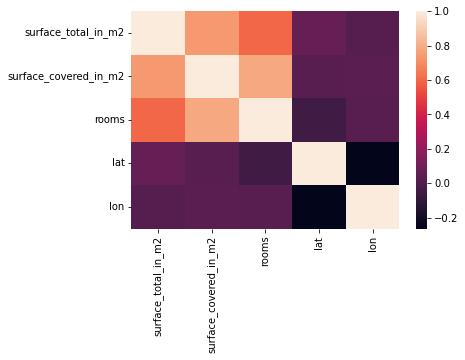

In [38]:
# Plot a correlation heatmap of the remaining numerical features in df
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr() # Since "price_aprox_usd" will be my target, I don't need to include it
sns.heatmap(corr);

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_total_in_m2    4752 non-null   float64
 2   surface_covered_in_m2  6582 non-null   float64
 3   rooms                  5286 non-null   float64
 4   lat                    6316 non-null   float64
 5   lon                    6316 non-null   float64
 6   neighborhood           6582 non-null   object 
dtypes: float64(6), object(1)
memory usage: 360.1+ KB


Here, I can see that columns like `"surface_total_in_m2"` and `"rooms"` have a pretty large missing values. 

In [40]:
# Modify my wrangle function to remove columns so that there are no strongly correlated features in my feature matrix
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop features with high null counts
    df.drop(columns = ["floor","expenses"], inplace = True)
    
    # Drop low and high cardinality categorical variables
    df.drop(columns = ["operation", "property_type", "currency", "properati_url"], inplace=True)
    
    # Drop leaky columns
    df.drop(columns = [
            'price',
            'price_aprox_local_currency',
            'price_per_m2',
            'price_usd_per_m2'
    ],
            inplace=True)
    
    # Drop columns with multicolinearlity
    df.drop(columns = ["surface_total_in_m2","rooms"], inplace=True)
    
    return df

In [41]:
files = glob("data/buenos-aires-real-estate-*.csv")
files

['data/buenos-aires-real-estate-3.csv',
 'data/buenos-aires-real-estate-2.csv',
 'data/buenos-aires-real-estate-1.csv',
 'data/buenos-aires-real-estate-5.csv',
 'data/buenos-aires-real-estate-4.csv']

In [42]:
frames = [wrangle(file) for file in files]
df = pd.concat(frames, ignore_index = True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,120000.0,55.0,-34.616004,-58.470506,Villa General Mitre
1,89000.0,37.0,-34.584712,-58.444927,Palermo
2,183495.0,57.0,-34.554652,-58.493644,Saavedra
3,95000.0,47.0,-34.610581,-58.479625,Villa del Parque
4,95000.0,35.0,-34.558227,-58.458357,Belgrano


In [43]:
df.isnull().sum() / len(df)

price_aprox_usd          0.000000
surface_covered_in_m2    0.000000
lat                      0.040413
lon                      0.040413
neighborhood             0.000000
dtype: float64

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB


It looks like I'm going to use the four features I've used in my previous models but, this time, I'm going to combine them.

## Split Data

In [45]:
# Create my feature matrix X_train and target vector y_train
target = "price_aprox_usd" # My target is "price_aprox_usd"
X_train = df.drop(columns=target)
y_train = df[target]

X_train.head()

,surface_covered_in_m2,lat,lon,neighborhood
0,55.0,-34.616004,-58.470506,Villa General Mitre
1,37.0,-34.584712,-58.444927,Palermo
2,57.0,-34.554652,-58.493644,Saavedra
3,47.0,-34.610581,-58.479625,Villa del Parque
4,35.0,-34.558227,-58.458357,Belgrano


In [46]:
y_train.head()

0    120000.0
1     89000.0
2    183495.0
3     95000.0
4     95000.0
Name: price_aprox_usd, dtype: float64

# Build Model

## Baseline

**Baseline Model**

In [47]:
# Calculate the baseline mean absolute error for my model
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", round(y_mean, 2))
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.84
Baseline MAE: 44860.10834274133


## Iterate

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB


In [49]:
# Create a pipeline named model that contains a OneHotEncoder, SimpleImputer, and Ridge predictor
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [50]:
# Check my work
check_is_fitted(model[-1])

## Evaluate

**Evaluate Model**

In [51]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 24207.107190330295


In [52]:
# Import my test data "data/buenos-aires-test-features.csv" into a DataFrame and generate a list of predictions using my model
X_test = pd.read_csv("data/buenos-aires-test-features.csv")

In [53]:
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    231122.403569
1    162572.942392
2     68477.949626
3     63521.438989
4    105694.463885
dtype: float64

# Communicate Results

Now I can look at two ways I might deploy this model. My goal is to wrap my model in a function so that a programmer can provide inputs and then receive a prediction as output. 

**Prediction Function**

In [54]:
# Create a function "make_prediction" that takes four arguments (area, lat, lon, and neighborhood) and returns my model's prediction for an apartment price
def make_prediction(area, lat, lon, neighborhood):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat, 
        "lon": lon, 
        "neighborhood": neighborhood
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [55]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $250775.11'

Another type of deployment is creating and interactive dashboard, where a user can supply values and receive a prediction. I'll create one using [Jupyter Widgets](https://ipywidgets.readthedocs.io/en/latest/index.html).

**Interactive Dashboard MVP**

In [56]:
# Add my "make_prediction" to the interact widget and then adjust the widget to see how predicted apartment price changes
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);


interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…